# Flight Delay Analysis

In this notebook I will focus on utilizing data analysis methods to solve the following questions:

1. When is the best time of day, day of the week, and time of year to fly to minimise delays?

2. How does the number of people flying between different locations change over time?

3. Can you detect cascading failures as delays in one airport create delays in others?

4. Use the available variables to construct a model that predicts delays.

## Content

- [EDA and Data Preprocessing](#index1)

- [Q1. When is the best time of day, day of the week, and time of year to fly to minimise delays?](#index2)
    - [Q1a. Best time of day](#index6)
    - [Q1b. Best day of week](#index7)
    - [Q1c. Best time of year](#index8)

- [Q2. How does the number of people flying between different locations change over time?](#index3)
    - [Lineplot](#index9)
    - [Heatmap](#index10)
    - [Lineplot(with destination)](#index11)

- [Q3. Can you detect cascading failures as delays in one airport create delays in others?](#index4)

- [Q4. Use the available variables to construct a model that predicts delays.](#index5)
    - [Feature Selection](#index15)
    - [Predictive Models](#index16)
        - [Linear Regression](#index12)
        - [Lasso Regression](#index13)
        - [Ridge Regression](#index14)

## <span id = 'index1'> EDA and Data Preprocessing</span>

In [69]:
#import all the necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import scipy.stats as stats
import statsmodels.api as sm
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

In [20]:
#Read in the data from 2007-2008
df = pd.concat([pd.read_csv(str(i) + '.csv') for i in ['./2006', './2007']])

In [72]:
#Take a glance at the number of rows and columns in the dataframe
df.shape

(14595137, 29)

In [73]:
#Take a look at the top five data in the dataframe
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2006,1,11,3,743.0,745,1024.0,1018,US,343,...,45,13,0,NaN,0,0,0,0,0,0
1,2006,1,11,3,1053.0,1053,1313.0,1318,US,613,...,27,19,0,NaN,0,0,0,0,0,0
2,2006,1,11,3,1915.0,1915,2110.0,2133,US,617,...,4,11,0,NaN,0,0,0,0,0,0
3,2006,1,11,3,1753.0,1755,1925.0,1933,US,300,...,16,10,0,NaN,0,0,0,0,0,0
4,2006,1,11,3,824.0,832,1015.0,1015,US,765,...,27,12,0,NaN,0,0,0,0,0,0


**After a simple glance at the dataset, we now start to deal with the missing values in the dataset.**

In [74]:
#Count the missing value of each column
df.isna().sum()

Year                        0
Month                       0
DayofMonth                  0
DayOfWeek                   0
DepTime                282682
CRSDepTime                  0
ArrTime                316047
CRSArrTime                  0
UniqueCarrier               0
FlightNum                   0
TailNum                    22
ActualElapsedTime      316047
CRSElapsedTime            998
AirTime                316047
ArrDelay               316047
DepDelay               282682
Origin                      0
Dest                        0
Distance                    0
TaxiIn                      0
TaxiOut                     0
Cancelled                   0
CancellationCode     14312454
Diverted                    0
CarrierDelay                0
WeatherDelay                0
NASDelay                    0
SecurityDelay               0
LateAircraftDelay           0
dtype: int64

In [21]:
#Calculate the number of cancelled and diverted flights
len(df[df['Cancelled'] == 1]) + len(df[df['Diverted'] == 1])

316047

When manually look into the table, I notice that the value of `AirTime` and `ArrDelay` is always **NAN** when the flight is cancelled or diverted. Being inspired by that, I calculate the number of cancelled or diverted filghts and is the same as the number of the missing values in `AirTime` and `ArrDelay`.

In [22]:
#Extract the dataframe that only contains flights that are not cancelled or diverted
df = df[(df['Cancelled'] == 0) & (df['Diverted'] == 0)]

In [77]:
df.isna().sum()

Year                        0
Month                       0
DayofMonth                  0
DayOfWeek                   0
DepTime                     0
CRSDepTime                  0
ArrTime                     0
CRSArrTime                  0
UniqueCarrier               0
FlightNum                   0
TailNum                     0
ActualElapsedTime           0
CRSElapsedTime              0
AirTime                     0
ArrDelay                    0
DepDelay                    0
Origin                      0
Dest                        0
Distance                    0
TaxiIn                      0
TaxiOut                     0
Cancelled                   0
CancellationCode     14279089
Diverted                    0
CarrierDelay                0
WeatherDelay                0
NASDelay                    0
SecurityDelay               0
LateAircraftDelay           0
dtype: int64

Luckily, after removing the records of cancelled or diverted flights, no more missing values exist except in the `CancellationCode` column. However, since the `CancellationCode` column doesn't contains useful information for our anaysis, we can directly remove it from the dataframe.

In [23]:
#Drop the `CancellationCode` column
df = df.drop(['CancellationCode'], axis = 1)

## <span id = 'index2'>Q1. When is the best time of day, day of the week, and time of year to fly to minimise delays?</span>

To analysis when is the best time to minimise delays, we separately look into each subquestions.

In [6]:
#Create a new dataframe for Q1
Q1_df = pd.DataFrame()

### <span id = 'index6'>Q1a The best time of day to minimise delays</span>

To make sure we only consider about the records of flights that are delayed at the arrival, we need to extract the record with value of `ArrDelay` bigger than 0.

In [7]:
#Select the data that are exactly delay
tmp = df[df['ArrDelay'] > 0]

For Q1a, we first separate a whole day into 24 timings to look at the average delay of each timing.

Create a new column in `Q1_df` representing the timing based on the `CRSArrTime` column of `tmp`

In [8]:
#Convert the `CRSArrTime` to 24 timings
Q1_df['timing'] = pd.to_datetime(tmp['CRSArrTime'], unit='h').dt.strftime("%H")
Q1_df.head()

,timing
0,10
5,16
6,13
7,20
14,16


In [9]:
#Calculate the delay time for each flight record
Q1_df['DepDelay'] = tmp['DepDelay']
Q1_df['ArrDelay'] = tmp['ArrDelay']
Q1_df.head()

,timing,DepDelay,ArrDelay
0,10,-2.0,6.0
5,16,-3.0,2.0
6,13,5.0,20.0
7,20,-3.0,7.0
14,16,0.0,5.0


In [10]:
#Calculate the average delay time for each timing
delay_l = Q1_df.groupby(['timing']).mean()

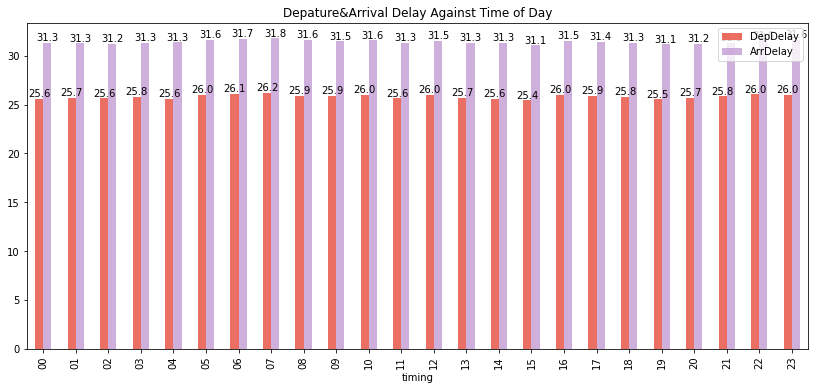

In [14]:
#Make the visualization of the mean delay time accross timings
ax = delay_l[['DepDelay','ArrDelay']].plot(kind='bar',alpha=0.8, figsize=[14,6], color = ['#E74C3C', '#C39BD3'])
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height(), '{:.1f}'.format(p.get_height()), ha='center', va='bottom')
plt.title('Depature&Arrival Delay Against Time of Day')
plt.show()

**Being inspired from the plot, we can know that the flights around `15:00` has the minimum avrage depature delay and average arrival delay.**

Besides, we can also devide the day into four parts: Morning, Afternoon, Evening and Night to look at the average delay of each time period. 

According to the definition of time:

- Morning: 4:00am - 11:59am
    
- Afternoon: 12:00pm - 7:59 pm

- Evening: 8:00pm - 10:50pm

- Night: 11:00pm - 3:59am

Define a function `time_of_day` to get the time of day.

In [15]:
def time_of_day(data):
    if 400 <= data < 1200:
        return 'Morning'
    elif 12 <= data < 2000:
        return 'Afternoon'
    elif 2000 <= data < 2300:
        return 'Evening'
    else:
        return 'Night'

Create a new column in `Q1_df` representing the time of day based on the `CRSArrTime` column of `tmp`

In [16]:
tod = []

for CRS in tmp['CRSArrTime']:
    tod.append(time_of_day(CRS))
    
Q1_df['time_of_day'] = tod

In [17]:
#Calculate the average delay based on time of day
part_delay_l = Q1_df.groupby(['time_of_day']).mean()

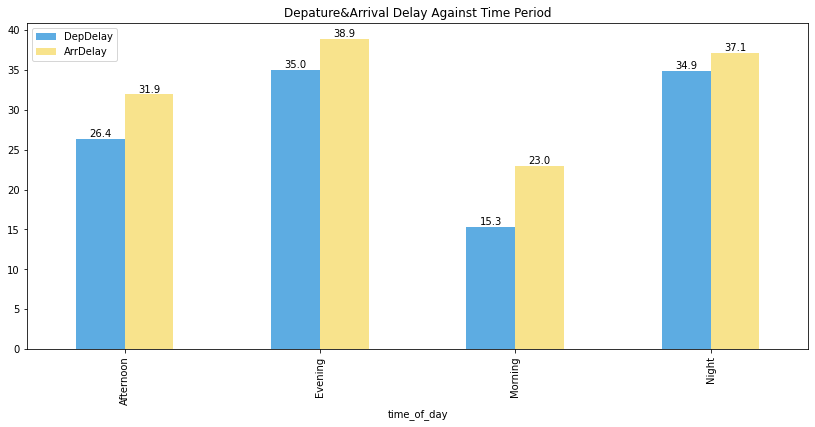

In [33]:
#Make the visualization of the mean delay time accross timings
ax = part_delay_l[['DepDelay','ArrDelay']].plot(kind='bar',alpha=0.8, figsize=[14,6], color = ['#3498DB', '#F7DC6F'])
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height(), '{:.1f}'.format(p.get_height()), ha='center', va='bottom')
plt.title('Depature&Arrival Delay Against Time Period')  
plt.show()

**Being inspired from the bar chart, we can know that when considering the period of time to buy plane ticket, the flights in the morning between `4:00am - 11:59am` has the minimum average delay.**

### <span id = 'index7'>Q1b. The best day of the week to minimise delays</span>

In [19]:
Q1_df['DayOfWeek'] = tmp['DayOfWeek']

In [20]:
#Calculate the avarage delay based on day of week
dow_l = Q1_df.groupby(['DayOfWeek']).mean()

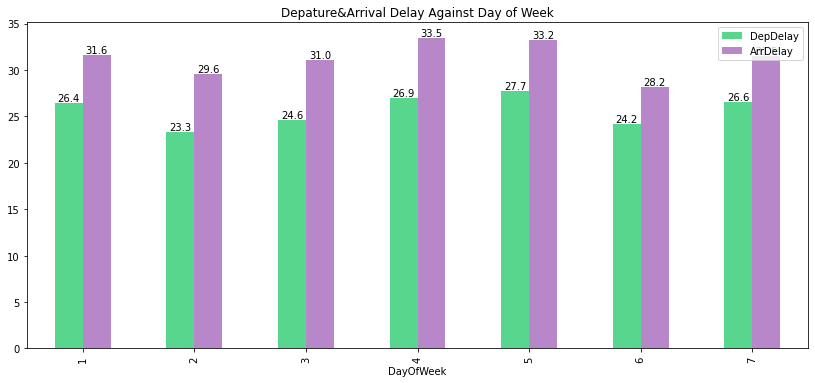

In [21]:
#Make the visualization of the mean delay time accross timings
ax = dow_l[['DepDelay','ArrDelay']].plot(kind='bar',alpha=0.8, figsize=[14,6], color = ['#2ECC71', '#A569BD'])
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height(), '{:.1f}'.format(p.get_height()), ha='center', va='bottom')
plt.title('Depature&Arrival Delay Against Day of Week')
plt.show()

**From the part chart we can know that the best day of week to minimise the depature delay is `Tuesday` and the best day of week to minimise the arrival delay is `Saturday`.**

### <span id = 'index8'>Q1c. The beset time of year to minimise delays</span>

In [23]:
Q1_df['Month'] = tmp['Month']

In [24]:
#Calculate the average delay based on the month
toy_l = Q1_df.groupby(['Month']).mean()

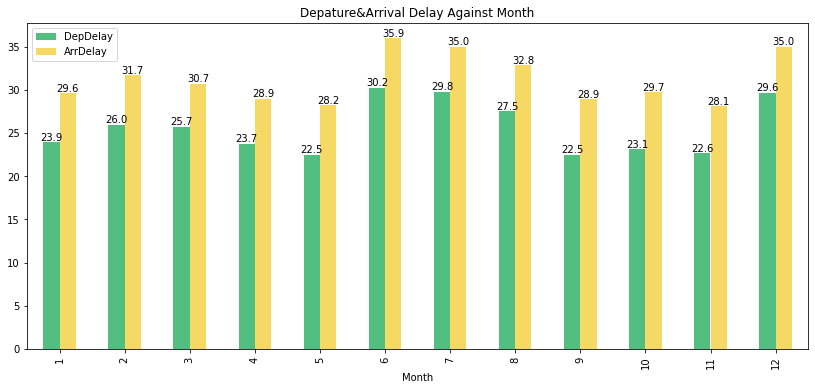

In [25]:
#Make the visualization of the mean delay time accross timings
ax = toy_l[['DepDelay','ArrDelay']].plot(kind='bar',alpha=0.8, figsize=[14,6], color = ['#27AE60', '#F4D03F'])
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height(), '{:.1f}'.format(p.get_height()), ha='center', va='bottom')
plt.title('Depature&Arrival Delay Against Month')
plt.show()

**From the part chart we can know that according to the data accross 2006-2007, `November` is the best time of the year to fly to minimise the delays.**

## <span id = 'index3'>Q2. How does the number of people flying between different locations change over time?</span>

In [27]:
#Extract the data with `year` and `month` column and calcuate the number of people flying 
Q2_df = df[['Year', 'Month']]
Q2_df = Q2_df.groupby(['Year', 'Month'], as_index = False).size()

In [28]:
Q2_df.head()

,Year,Month,size
0,2006,1,570130
1,2006,2,518645
2,2006,3,596578
3,2006,4,577718
4,2006,5,594626


### <span id = 'index9'>Lineplot</span>

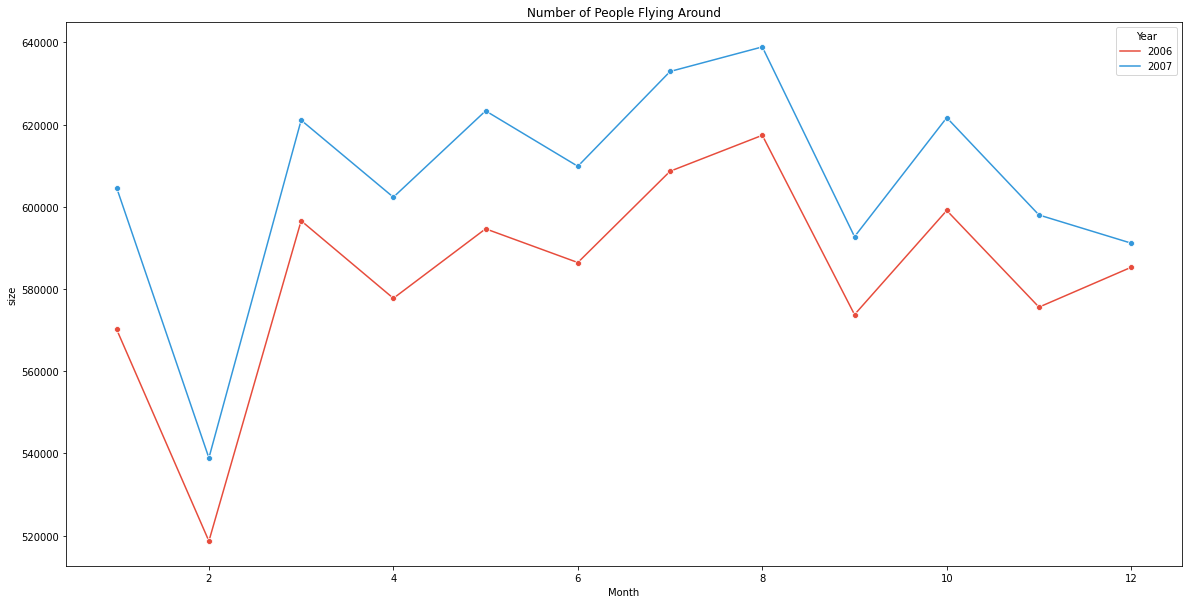

In [48]:
#Draw a lineplot to show the relationship between the number of people flying around against time
fig,ax = plt.subplots(1, figsize = (20,10))
lineplot1 = sns.lineplot(x = 'Month', y = 'size', hue = 'Year', data = Q2_df, marker = 'o', ax = ax, palette = ['#E74C3C', '#3498DB'])
plt.title('Number of People Flying Around')
plt.show()

### <span id = 'index10'>Heatmap</span>

Optionally, we can also use heatmap to visualize the number of people flying change over time.

<AxesSubplot:xlabel='Month', ylabel='Year'>

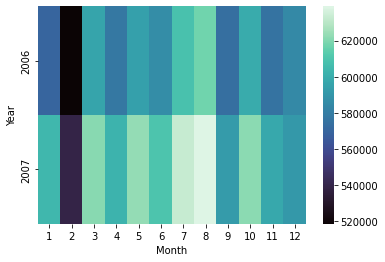

In [36]:
#Turn the dataframe to table form
heat_df = Q2_df.pivot_table(index = 'Year', columns = 'Month', values = 'size')

#Draw the heatmap
sns.heatmap(heat_df, cmap = "mako")

From the lineplot we can clearly see that according to the data from `2006-2007`, the number of people flying between different locations reduce dramatically on `Febuary` and back to normal on `March`. 

The peak of number of people flying between different locations usually appears on `August`.

In [42]:
#Dataframe with `Dest` column
Q2_df_Dest = df[['Year', 'Month', 'Dest']]
Q2_df_Dest = Q2_df_Dest.groupby(['Year', 'Month', 'Dest'], as_index = False).size()

### <span id = 'index11'>Lineplot(with destination)</span>

We can also draw a lineplot to look at the number of people flying around against locations, due to the various locations, here we just pick the top five locations for the visualization

In [45]:
#Choose the top 5 destination for visualization
Dest_l = Q2_df_Dest['Dest'][:6]
Q2_df_Dest = Q2_df_Dest.loc[Q2_df_Dest['Dest'].isin(Dest_l)]

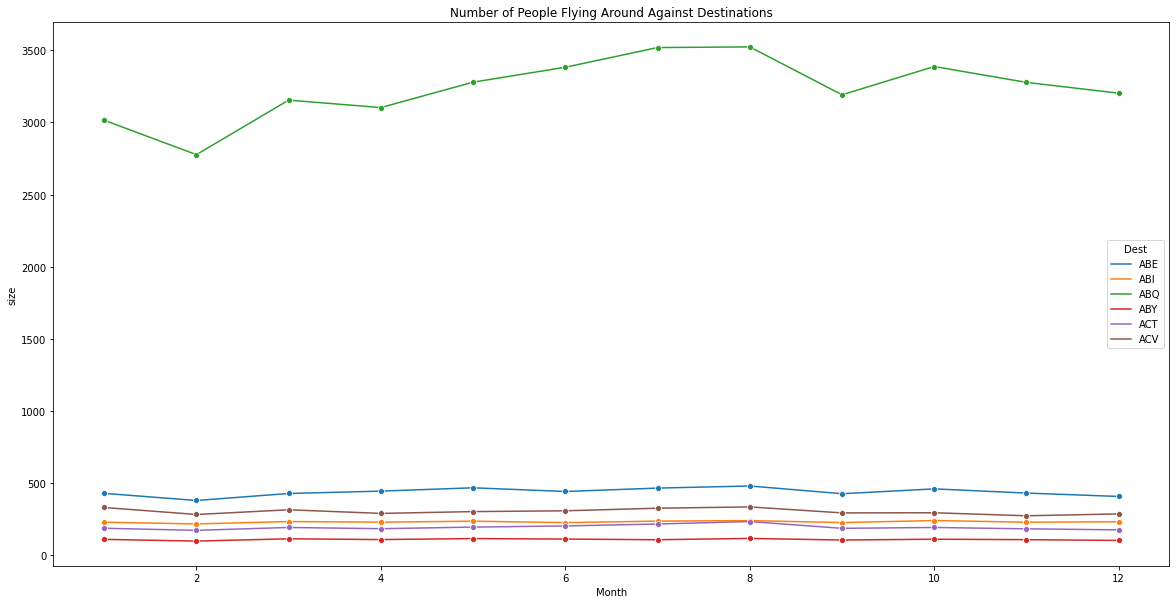

In [49]:
#Draw a lineplot to show the relationship between the number of people flying around different locations against destinations
fig,ax = plt.subplots(1, figsize = (20,10))
lineplot1 = sns.lineplot(x = 'Month', y = 'size', hue = 'Dest', errorbar = None, marker = 'o', data = Q2_df_Dest, ax = ax)
plt.title('Number of People Flying Around Against Destinations')
plt.show()

## <span id = 'index4'>Q3. Can you detect cascading failures as delays in one airport create delays in others?</span>

To detect the cascading failures as delays in one airport create delays in others, the essential problem is to check whether column `ArrDelay` is highly correlated to column `DepDelay`.

According to our recognition, a delay in arrival normally lead to a delay in departure. Therefore, we can try to use linear regression methods to test whether their is a tight correlation between `ArrDelay` and `DepDelay`.

In [111]:
#Create a copy of the orignial dataframe for Q3
Q3_df = df.copy()

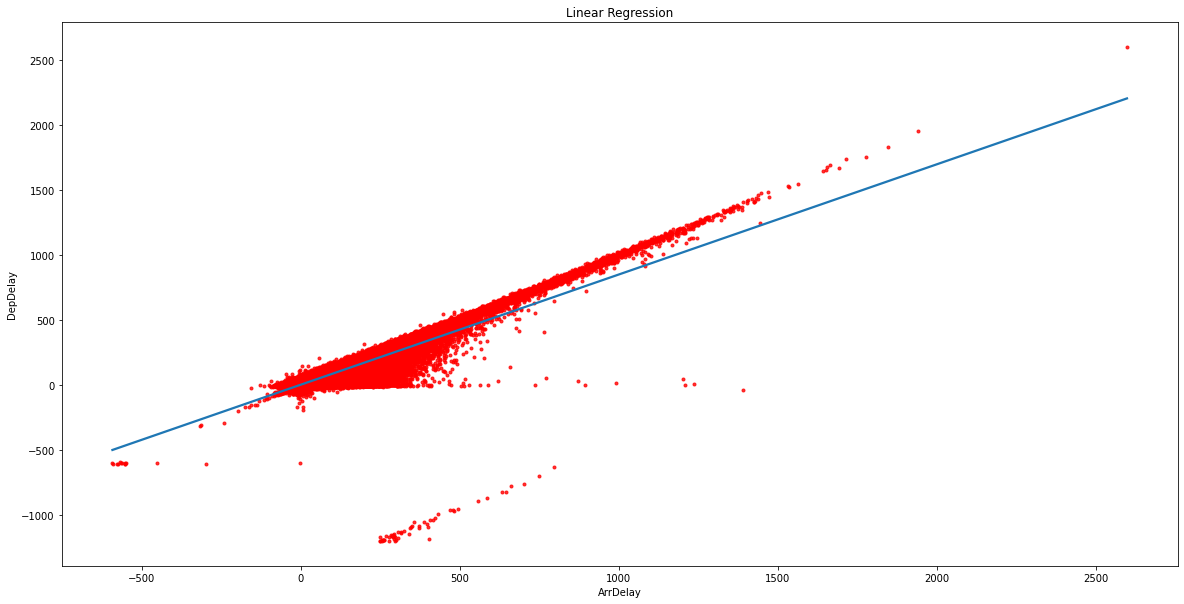

In [323]:
#Draw a regression plot to see whether a linear regression can descirbe the relationship between `ArrDelay` and `DepDelay`
fig,ax = plt.subplots(1, figsize = (20,10))
ax = sns.regplot(x = Q3_df['ArrDelay'], y = Q3_df['DepDelay'], order = 1, ci = None, scatter_kws={'color':'r', 's':9})
plt.title('Linear Regression')
plt.show()

In [112]:
#Set the independent and dependent value for regression
x = Q3_df['ArrDelay']
y = Q3_df['DepDelay']

OLS_model = sm.OLS(y, sm.add_constant(x)).fit() 
OLS_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               DepDelay   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                 8.568e+07
Date:                Sun, 05 Mar 2023   Prob (F-statistic):               0.00
Time:                        22:05:21   Log-Likelihood:            -5.7049e+07
No. Observations:            14279090   AIC:                         1.141e+08
Df Residuals:                14279088   BIC:                         1.141e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7111      0.004    756.083      0.000       2.704       2.718
ArrDelay       0.8476   9.16e-05   9256.600      0.000       0.847       0.848
==============================================================================
Omnibus:                 18891803.410   Durbin-Watson:                   1.711
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     165674420240.262
Skew:                          -6.206   Prob(JB):                         0.00
Kurtosis:                     530.549   Cond. No.                         40.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Since the **R-Square** of the linear regression is over 0.85, it suggests that column `DepDelay` is highly correlated to `ArrDelay`.

In [225]:
print('The R-Square of the Ordinal Least Squares model is: ', OLS_model.rsquared)

The R-Square of the Ordinal Least Squares model is:  0.8571573099672916


Beside of linear regression, a hyphothesis test can also be performed to test the significance of the relationship between `ArrDelay` and `DepDelay`.

Here are our hyphothesis:

$H0$: `DepDelay` and `ArrDelay` are independent

$H1$: `DepDelay` and `ArrDelay` are dependent

The significance level we set is `5%`, which means that if the P-value is less than `0.05`, we will reject the null hyphothesis.

In [113]:
#Calculate the correlation coefficient and P-value for the two features
corr, pval = stats.pearsonr(x, y)
print('The correlation coefficient is ', corr)
print('The P-value is ', pval)
if pval < 0.05:
    print('We reject the null hyphothesis')

The correlation coefficient is  0.9258279051568823
The P-value is  0.0
We reject the null hyphothesis


Since the P-value is less than 0.05, we will reject the null hyphothesis and draw a conclusion that the `ArrDelay` and `DepDelay` are highly correlated, which **means that we can detect cascading failures as delays in one airport create delays in others.**

## <span id = 'index5'>Q4. Use the available variables to construct a model that predicts delays.</span>

In [25]:
#Copy a dataframe for Q4
Q4_df = df.copy()

### <span id = 'index15'>Feature Selection</span>

In [7]:
Q4_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14279090 entries, 0 to 7453214
Data columns (total 29 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Year               int64         
 1   Month              int64         
 2   Day                int64         
 3   DayOfWeek          int64         
 4   DepTime            float64       
 5   CRSDepTime         int64         
 6   ArrTime            float64       
 7   CRSArrTime         int64         
 8   UniqueCarrier      object        
 9   FlightNum          int64         
 10  TailNum            object        
 11  ActualElapsedTime  float64       
 12  CRSElapsedTime     float64       
 13  AirTime            float64       
 14  ArrDelay           float64       
 15  DepDelay           float64       
 16  Origin             object        
 17  Dest               object        
 18  Distance           int64         
 19  TaxiIn             int64         
 20  TaxiOut            int6

For the feature selection, we first manually look into the information of the features to see whether there are features can be directly removed.

After look into the information, there are several findings:

1. Column `Cancelled` and `Diverted` can be directly removed since these columns doesn't provide useful information for the predictive model.

2. Object variables `Origin`, `Dest`, `FlightNum` and `UniqueCarrier` can be removed.

3. Columns such as `WeatherDelay` can be removed since the `ArrDelay` and `DepDelay` already contains the information of these columns.

4. Datetime data can be removed.

In [26]:
#Remove the useless column from the dataframe
Q4_df = Q4_df.drop(['Year', 'Month', 'Day', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest', 'Cancelled', 'Diverted', 'FlightNum', 'TailNum', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay','datetime'], axis = 1)

In [10]:
Q4_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14279090 entries, 0 to 7453214
Data columns (total 12 columns):
 #   Column             Dtype  
---  ------             -----  
 0   DepTime            float64
 1   CRSDepTime         int64  
 2   ArrTime            float64
 3   CRSArrTime         int64  
 4   ActualElapsedTime  float64
 5   CRSElapsedTime     float64
 6   AirTime            float64
 7   ArrDelay           float64
 8   DepDelay           float64
 9   Distance           int64  
 10  TaxiIn             int64  
 11  TaxiOut            int64  
dtypes: float64(7), int64(5)
memory usage: 1.4 GB


In [27]:
#Calcualte the correlation between each feature
corr = Q4_df.corr()
corr

,DepTime,CRSDepTime,ArrTime,CRSArrTime,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut
DepTime,1.000000,0.964529,0.712908,0.790024,-0.012467,-0.012923,-0.027411,0.196156,0.213594,-0.014650,0.022778,0.055265
CRSDepTime,0.964529,1.000000,0.692699,0.784276,-0.008089,-0.007059,-0.019150,0.137029,0.151931,-0.006874,0.018003,0.044951
ArrTime,0.712908,0.692699,1.000000,0.870398,0.034761,0.031066,0.013550,0.089645,0.089675,0.023125,0.032041,0.060811
CRSArrTime,0.790024,0.784276,0.870398,1.000000,0.049859,0.050333,0.035276,0.132866,0.145004,0.042751,0.006573,0.065540
ActualElapsedTime,-0.012467,-0.008089,0.034761,0.049859,1.000000,0.979508,0.928280,0.082131,0.026559,0.957839,0.032044,0.275034
CRSElapsedTime,-0.012923,-0.007059,0.031066,0.050333,0.979508,1.000000,0.931882,0.000881,0.021303,0.976995,0.019399,0.149767
AirTime,-0.027411,-0.019150,0.013550,0.035276,0.928280,0.931882,1.000000,0.010335,-0.001488,0.921604,-0.278474,0.104053
ArrDelay,0.196156,0.137029,0.089645,0.132866,0.082131,0.000881,0.010335,1.000000,0.925828,-0.006344,0.060301,0.328873
DepDelay,0.213594,0.151931,0.089675,0.145004,0.026559,0.021303,-0.001488,0.925828,1.000000,0.011172,0.039547,0.099435
Distance,-0.014650,-0.006874,0.023125,0.042751,0.957839,0.976995,0.921604,-0.006344,0.011172,1.000000,0.013857,0.107935


We can draw a **heatmap** based on the **correlation** to see whether there are features that are highly correlated so that we can directly remove one of them to reduce the feature dimensionality.

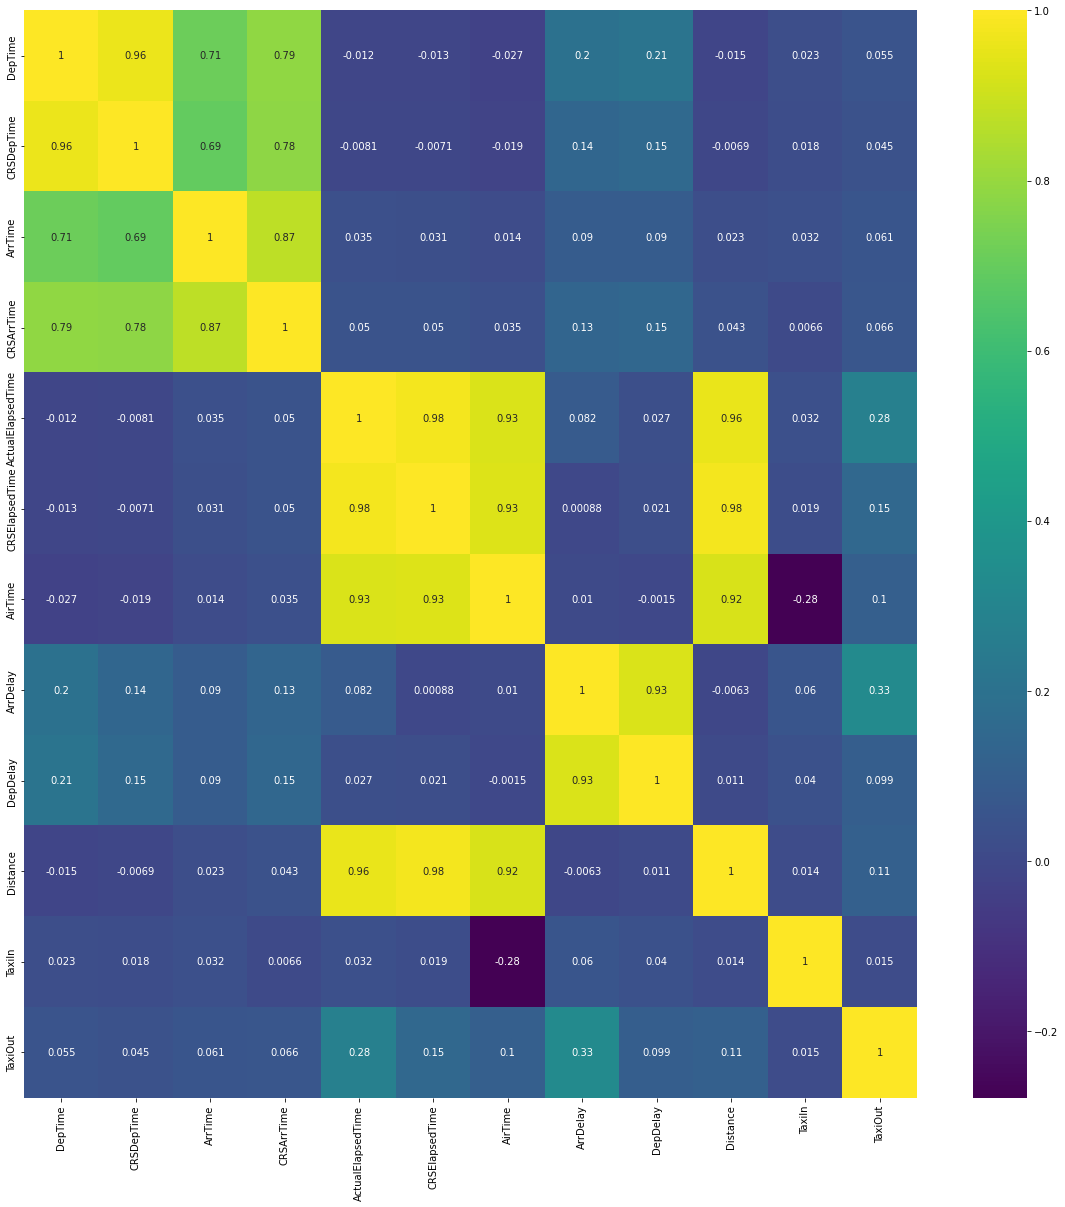

In [40]:
#Draw the heatmap based on correlation
fig, ax = plt.subplots(figsize = (20, 20))
sns.heatmap(corr, annot = True, ax = ax, cmap = 'viridis')
plt.show()

Set the threshold to `0.95` and drop the features with a correlation higher than the threshold

In [28]:
# Set a threshold of 95% to drop those features with high correlation to reduce the number of features
threshold = 0.95 

highly_correlated = []
correlated_matrix = np.abs(corr) > threshold
for i in range(len(correlated_matrix.columns)):
    for j in range(i):
        if correlated_matrix.iloc[i, j]:
            colname = correlated_matrix.columns[i]
            highly_correlated.append(colname)
            
for h_c in highly_correlated:
    print(h_c + ' dropped.')
Q4_df = Q4_df.drop(highly_correlated, axis = 1)

CRSDepTime dropped.
CRSElapsedTime dropped.
Distance dropped.
Distance dropped.


In [344]:
Q4_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14279090 entries, 0 to 7453214
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   DepTime            float64
 1   ArrTime            float64
 2   CRSArrTime         int64  
 3   ActualElapsedTime  float64
 4   AirTime            float64
 5   ArrDelay           float64
 6   DepDelay           float64
 7   TaxiIn             int64  
 8   TaxiOut            int64  
dtypes: float64(6), int64(3)
memory usage: 1.4 GB


In [345]:
#Make sure there are no missing values
Q4_df.isna().sum()

DepTime              0
ArrTime              0
CRSArrTime           0
ActualElapsedTime    0
AirTime              0
ArrDelay             0
DepDelay             0
TaxiIn               0
TaxiOut              0
dtype: int64

### <span id = 'index16'>Predictive Models</span>

In [32]:
#Split the dataset to training and testing dataset
features = ['DepTime', 'CRSArrTime', 'ActualElapsedTime', 'AirTime', 'DepDelay', 'TaxiIn', 'TaxiOut']

x = Q4_df[features]
y = Q4_df['ArrDelay']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 1)

- <span id = 'index12'>**Linear Regression**</span>

Since there are no missing values, there is no need to add an imputer in the pipeline.

In [76]:
#Creating the pipeline for standard scaling and building the model
pipeline_lr = Pipeline(
    [('scaler', StandardScaler()), #Since the data are all numerical data, standard scaling should be performed
    ('lr', LinearRegression())]
)

In [77]:
#Train the model and make prediction
pipeline_lr.fit(x_train, y_train)

y_pred = pipeline_lr.predict(x_test)

#Use the R-Square score to evaluate the performance of the Linear Regression Model
lr_score = pipeline_lr.score(x_test, y_test)

print('The accuracy of Linear Regression is: ', lr_score)

The accuracy of Linear Regression is:  0.9156553636102837


In [78]:
lr_MSE = metrics.mean_squared_error(y_test, y_pred) # Calculating Mean Squared Error (MSE)
lr_r2 = metrics.r2_score(y_test, y_pred)

print('The Mean Square Error is: ', lr_MSE)
print('The R-Square is: ', lr_r2)

The Mean Square Error is:  121.29710095180282
The R-Square is:  0.9156553636102837


- <span id = 'index13'>**Lasso Regression**</span>

In [56]:
#Creating the pipeline for standard scaling and building the model
pipeline_ls = Pipeline(
    [('scaler', StandardScaler()), #Since the data are all numerical data, standard scaling should be performed
    ('ls', Lasso())]
)

ls_param = {'ls__alpha': [0.001, 0.01, 0.1, 1, 10]}

grid_ls = GridSearchCV(pipeline_ls, ls_param)

In [106]:
#Train the model and make prediction
grid_ls.fit(x_train, y_train)

y_pred = grid_ls.predict(x_test)

#Use the R-Square score to evaluate the performance of the Linear Regression Model
ls_score = grid_ls.score(x_test, y_test)

print('The accuracy of Lasso Regression is: ', ls_score)

The accuracy of Lasso Regression is:  0.9156553608192511


In [107]:
print('The best parameters for Lasso Regression is: ', grid_ls.best_params_)

The best parameters for Lasso Regression is:  {'r__alpha': 10}


In [60]:
ls_MSE = metrics.mean_squared_error(y_test, y_pred) # Calculating Mean Squared Error (MSE)
ls_r2 = metrics.r2_score(y_test, y_pred)

print('The Mean Square Error is: ', ls_MSE)
print('The R-Square is: ', ls_r2)

The Mean Square Error is:  121.29814118150038
The R-Square is:  0.9156546402805841


- <span id = 'index14'>**Ridge Regression**</span>

In [71]:
#Creating the pipeline for standard scaling and building the model
pipeline_r = Pipeline(
    [('scaler', StandardScaler()), #Since the data are all numerical data, standard scaling should be performed
    ('r', Ridge())]
)

r_param = {'r__alpha': [0.001, 0.01, 0.1, 1, 10]}

grid_r = GridSearchCV(pipeline_r, r_param)

In [108]:
#Train the model and make prediction
grid_r.fit(x_train, y_train)

y_pred = grid_r.predict(x_test)

#Use the R-Square score to evaluate the performance of the Linear Regression Model
r_score = grid_r.score(x_test, y_test)

print('The accuracy of Ridge Regression is: ', r_score)

The accuracy of Ridge Regression is:  0.9156553608192511


In [109]:
print('The best parameters for Ridge Regression is: ', grid_r.best_params_)

The best parameters for Ridge Regression is:  {'r__alpha': 10}


In [74]:
r_MSE = metrics.mean_squared_error(y_test, y_pred) # Calculating Mean Squared Error (MSE)
r_r2 = metrics.r2_score(y_test, y_pred)

print('The Mean Square Error is: ', r_MSE)
print('The R-Square is: ', r_r2)

The Mean Square Error is:  121.29710496562252
The R-Square is:  0.9156553608192511


Comparison of the accuracy of the three models

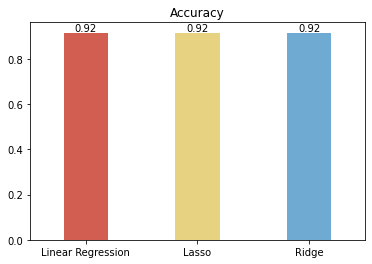

In [102]:
bar_width = 0.4

# Calculate the x positions of the bars
x_pos = np.arange(3)

# Plot the bars for each variable
ax = sns.barplot(x = ['Linear Regression', 'Lasso', 'Ridge'], y = [lr_score, ls_score, r_score], width = bar_width, palette = ['#E74C3C', '#F7DC6F', '#5DADE2'])
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height(), '{:.2f}'.format(p.get_height()), ha='center', va='bottom')
    
plt.title('Accuracy')
plt.show()

Comparison of the mean squared error of the three models

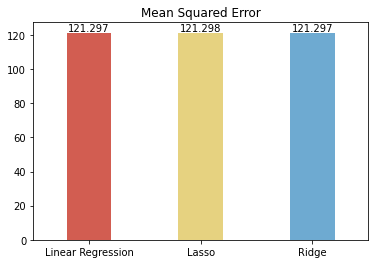

In [104]:
bar_width = 0.4

# Calculate the x positions of the bars
x_pos = np.arange(3)

# Plot the bars for each variable
ax = sns.barplot(x = ['Linear Regression', 'Lasso', 'Ridge'], y = [lr_MSE, ls_MSE, r_MSE], width = bar_width,  palette = ['#E74C3C', '#F7DC6F', '#5DADE2'])
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height(), '{:.3f}'.format(p.get_height()), ha='center', va='bottom')
    
plt.title('Mean Squared Error')
plt.show()